In [2]:
# ruff: noqa: E402
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

# Util to import functions from project root
p = Path.cwd()
root = next(
    (
        parent
        for parent in [p] + list(p.parents)
        if (parent / "pyproject.toml").exists()
    ),
    None,
)
if root is None:
    root = Path.cwd()
sys.path.insert(0, str(root))

from src.modelling.data_processing import DataFrameTransformer


In [2]:
df = pd.read_csv("../src/data/train_data.csv")
cols = df.columns.tolist()
df.head()

,row_id,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,106954,36,187159,True,0.809,0.269,0,-17.422,1,0.1020,0.659,0.006490,0.1200,0.480,127.011,4,swedish
1,464,54,145514,False,0.724,0.280,9,-12.788,1,0.0303,0.755,0.000000,0.3260,0.527,106.966,4,acoustic
2,14389,36,131226,False,0.765,0.387,7,-6.799,1,0.1470,0.908,0.000000,0.1850,0.839,159.966,4,children
3,62289,0,194706,False,0.598,0.447,8,-7.932,1,0.0404,0.224,0.000000,0.0704,0.365,123.855,4,j-pop
4,64081,0,200461,False,0.430,0.543,8,-6.296,1,0.0367,0.463,0.000523,0.0928,0.354,143.912,4,jazz


In [3]:
df.set_index("row_id", inplace=True)
df["explicit"] = df["explicit"].astype(int)
df.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,85500.000000,8.550000e+04,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000
mean,33.184877,2.282212e+05,0.086129,0.567258,0.641617,5.299357,-8.258863,0.637836,0.084694,0.315533,0.156024,0.213392,0.474164,122.068523,3.904749
std,22.303252,1.056850e+05,0.280556,0.173209,0.251390,3.557790,5.023892,0.480629,0.106209,0.332890,0.309588,0.190164,0.259196,29.981067,0.431324
min,0.000000,8.586000e+03,0.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740290e+05,0.000000,0.457000,0.473000,2.000000,-10.012000,0.000000,0.035900,0.016800,0.000000,0.098000,0.260000,99.071000,4.000000
50%,34.000000,2.130610e+05,0.000000,0.580000,0.685000,5.000000,-7.009000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.007000,4.000000
75%,50.000000,2.619625e+05,0.000000,0.695000,0.854000,8.000000,-5.004000,1.000000,0.084600,0.600000,0.048600,0.273000,0.683000,140.062000,4.000000
max,100.000000,5.237295e+06,1.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [4]:
# Check missing values
assert (df.isnull().sum() == 0).all()

cols_cat = [
    "explicit",
    "key",
    "mode",
    "track_genre",
    "time_signature",
]
cols_num = [
    "popularity",
    "duration_ms",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

df.dtypes


popularity            int64
duration_ms           int64
explicit              int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

time_signature
4    76417
3     6865
5     1374
1      723
0      121
Name: count, dtype: int64


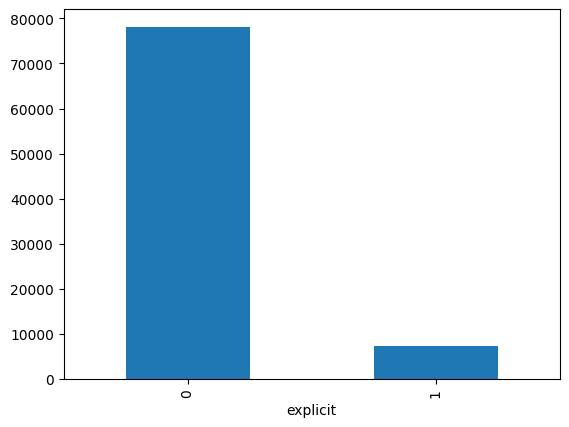

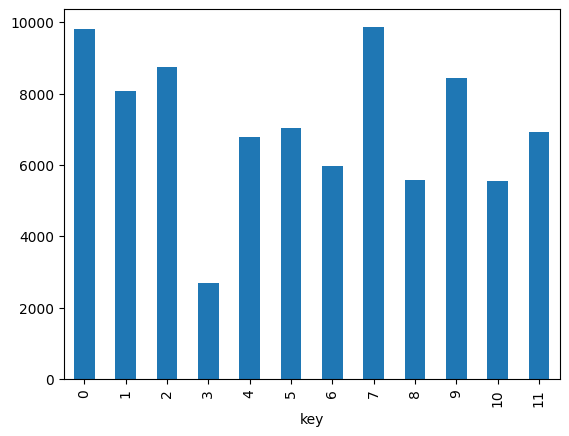

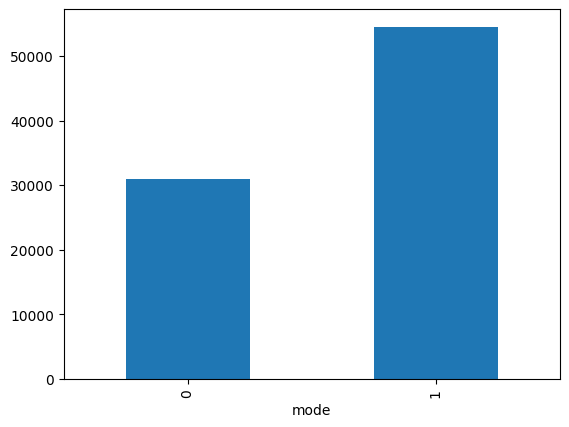

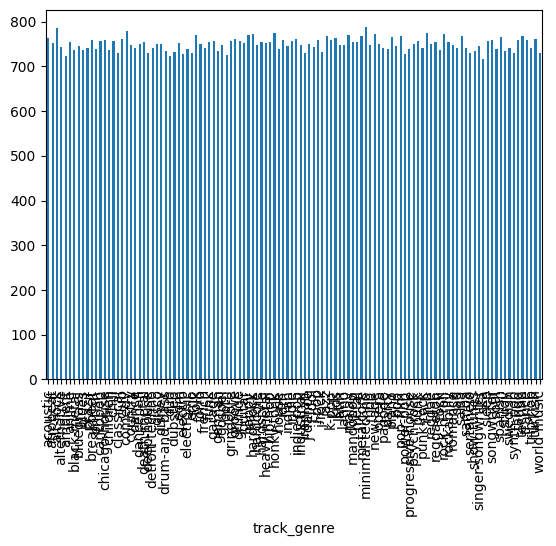

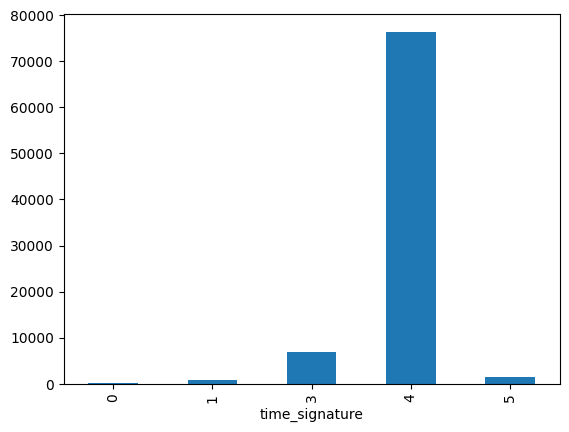

In [5]:
print(df["time_signature"].value_counts())

for col in cols_cat:
    # plt.hist(df[col], bins=df[col].nunique())  # type:ignore
    df[col].value_counts().sort_index().plot(kind="bar")
    plt.show()

# time_signature: 4 is super common, 3-1-5 rare, 0 very rare.


Number of genres: 114


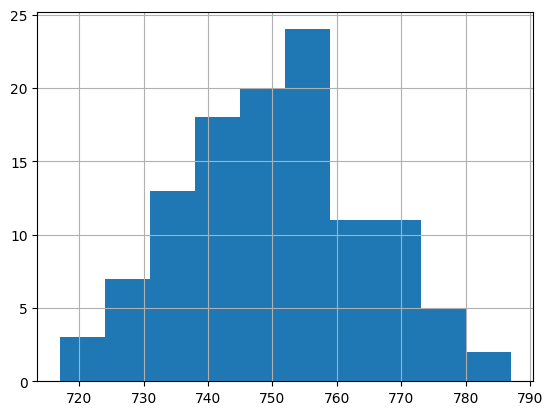

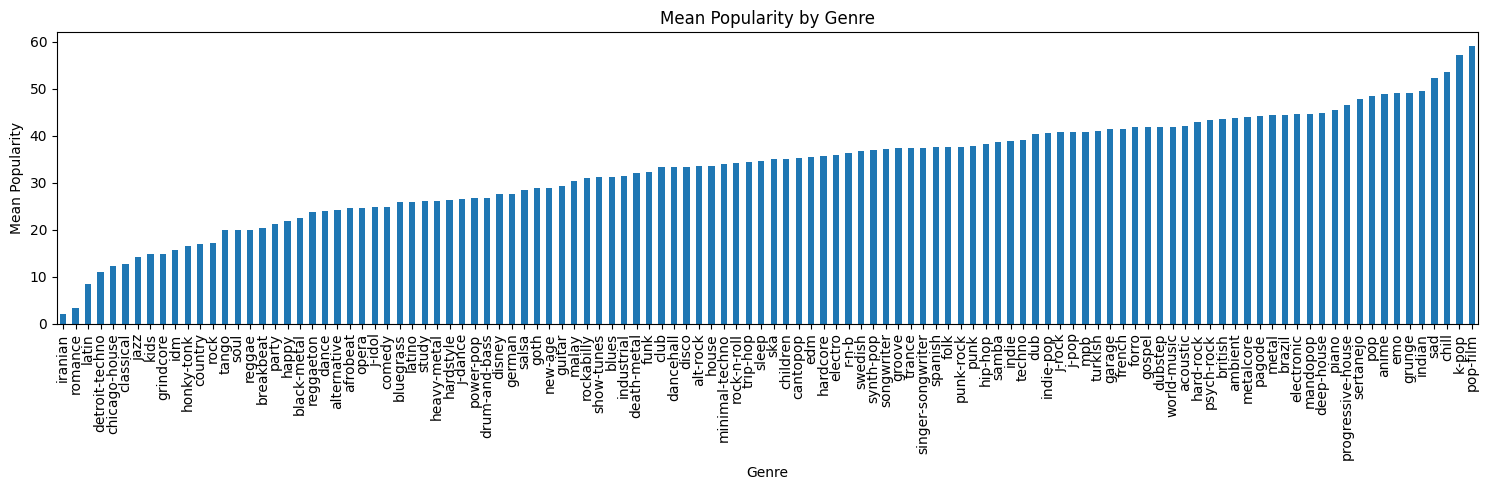

In [6]:
print("Number of genres:", len(df["track_genre"].unique()))
df["track_genre"].value_counts().hist()
plt.show()

# The dataset seems somewhat balanced in terms of genres, every genre has around 750 observations.
# The genre seems to bring of lot of information to predict popularity.
# There are 114 genres, we could transform each in a categorical variable, but it could be inefficient for some class of models.

# An idea would be, instead of predicting the popularity directly, to estimate the mean popularity by genre,
# and to predict, for a sample of genre X, the residuals (popularity - estimated_mean_popularity_genre_X).
# The final prediction would be the sum of the estimated mean popularity by genre and the predicted residuals.
# (We could even try ensemble learning, by training this model, and a more "classical" model).

mean_pop_by_genre = df.groupby("track_genre")["popularity"].mean().sort_values()  # type:ignore
plt.figure(figsize=(15, 5))
mean_pop_by_genre.plot(kind="bar")
plt.ylabel("Mean Popularity")
plt.xlabel("Genre")
plt.title("Mean Popularity by Genre")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



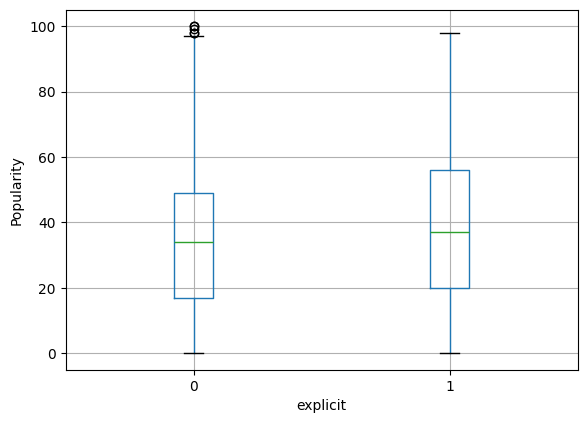

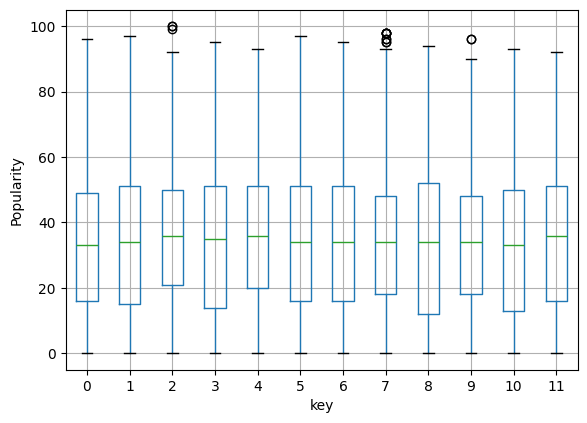

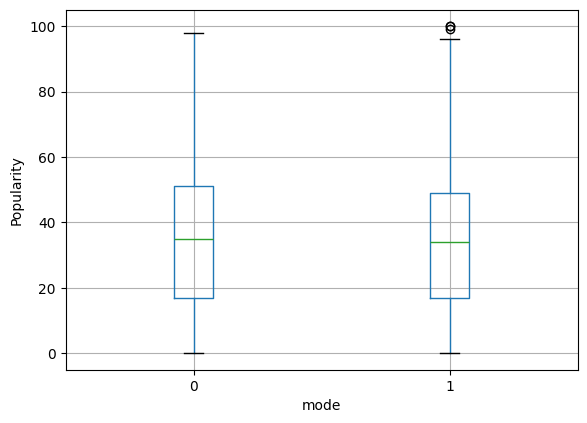

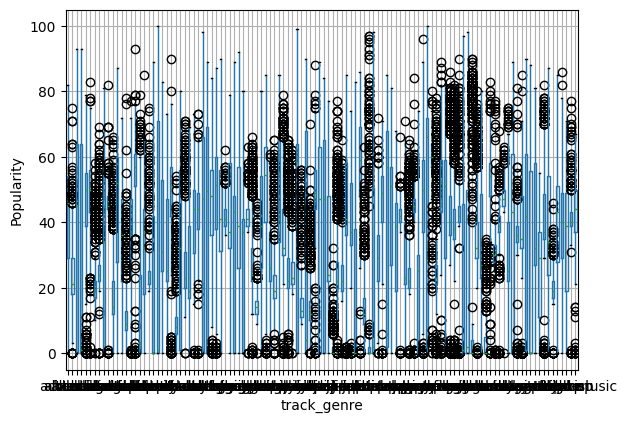

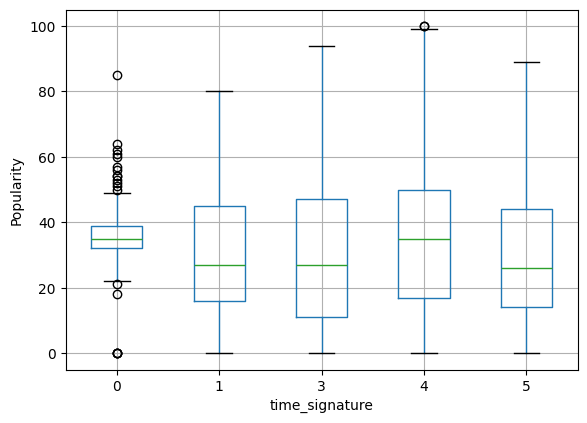

In [7]:
for col in cols_cat:
    df.boxplot(column="popularity", by=col)
    plt.title("")
    plt.suptitle("")
    plt.xlabel(f"{col}")
    plt.ylabel("Popularity")
    plt.show()

# time_signature: 1/2/5 seem quite similar, 4 is the most common and is different, 0 is rare and different.
# -> We could group the signatures by 3 categorical variable: is4, is0, is1-3-5

df_transformer = DataFrameTransformer(drop_cols=True, make_plots=True)
df = df_transformer.make_time_signature_cats(df)


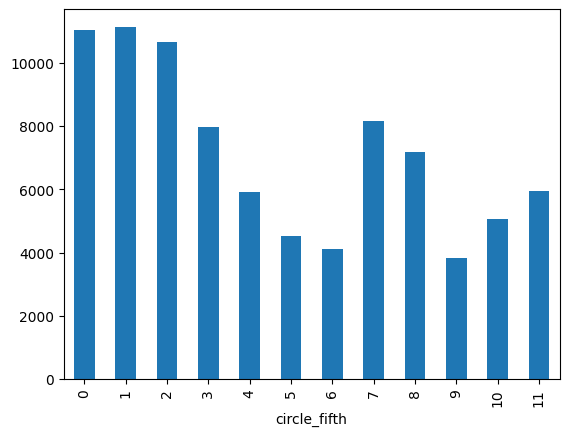

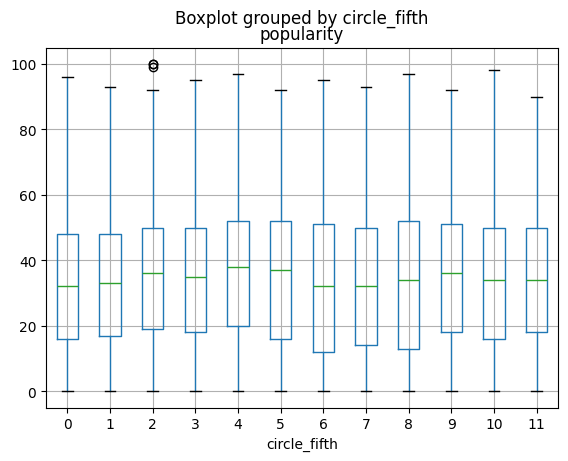

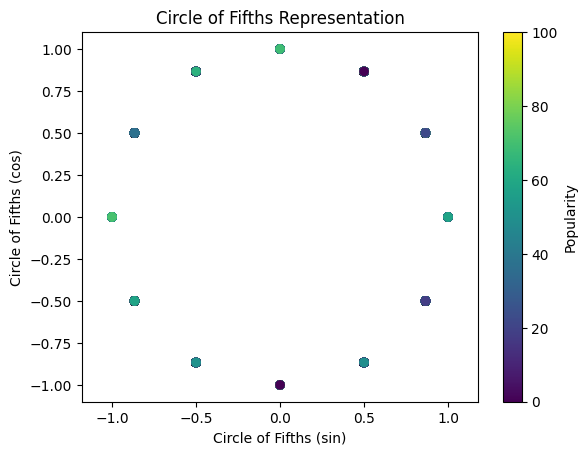

In [8]:
# The key and the mode doesn't seem to capture a lot of popularity information.
# Thanks to domain knowledge, we can engineer a new feature: the position in the circle of fifths.
# See: https://en.wikipedia.org/wiki/Circle_of_fifths#/media/File:Circle_of_fifths_deluxe_4.svg
# We get 12 categorical variables, we can either keep them as this or represent them with sin/cos.

df = df_transformer.make_circle_of_fifths(df)


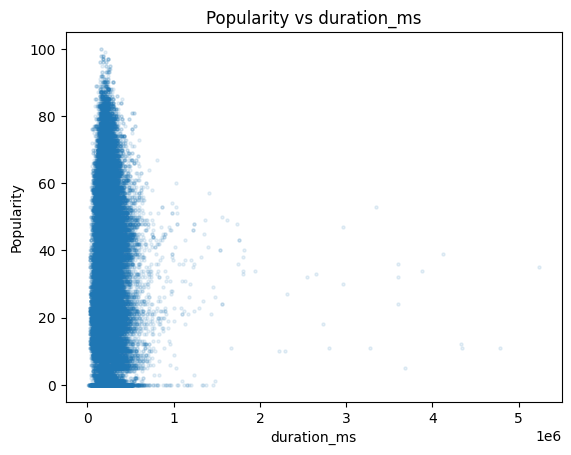

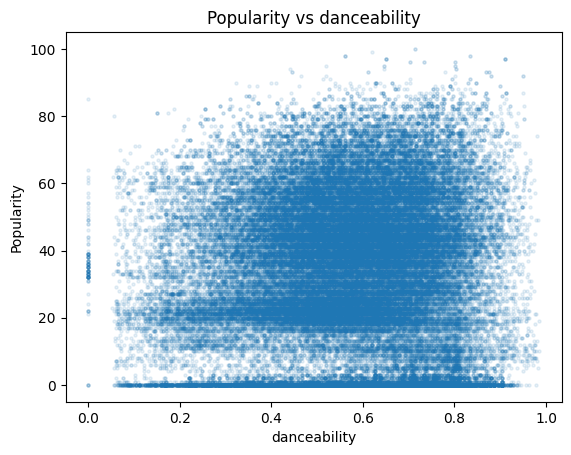

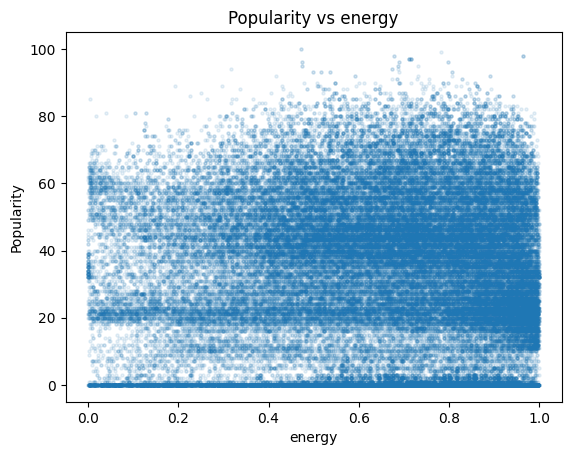

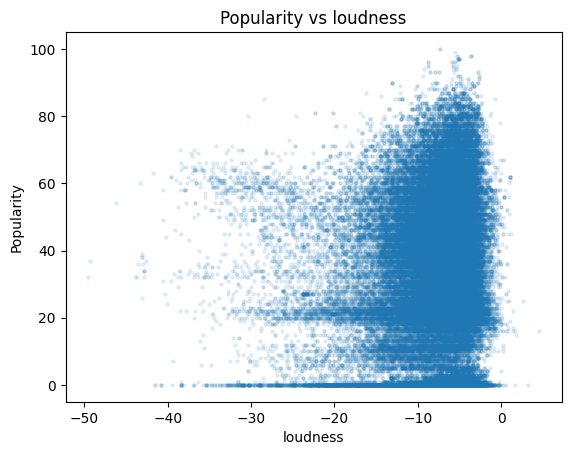

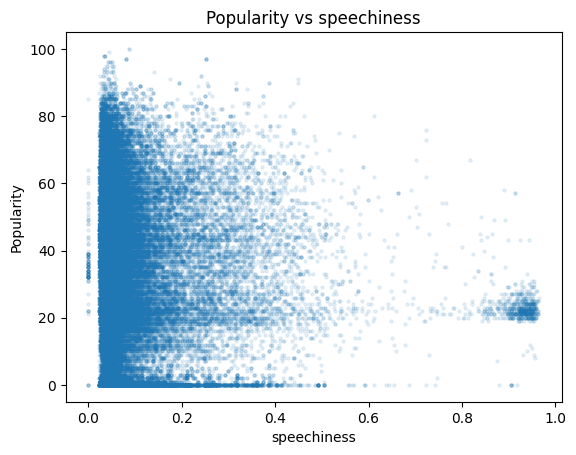

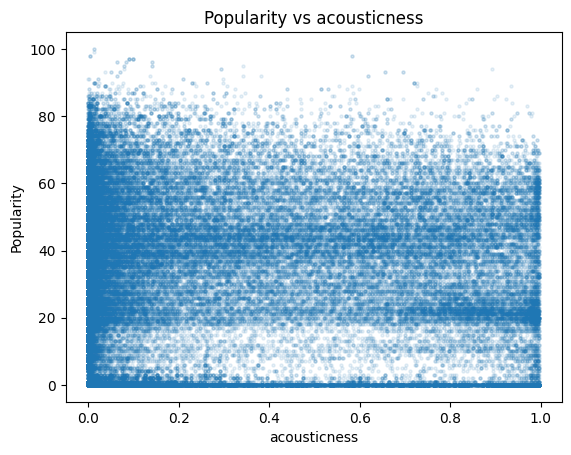

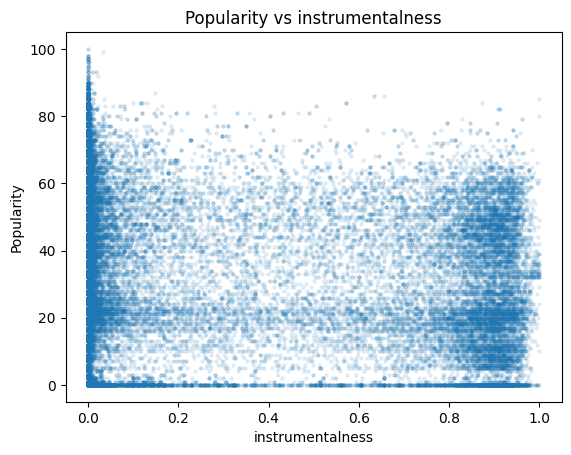

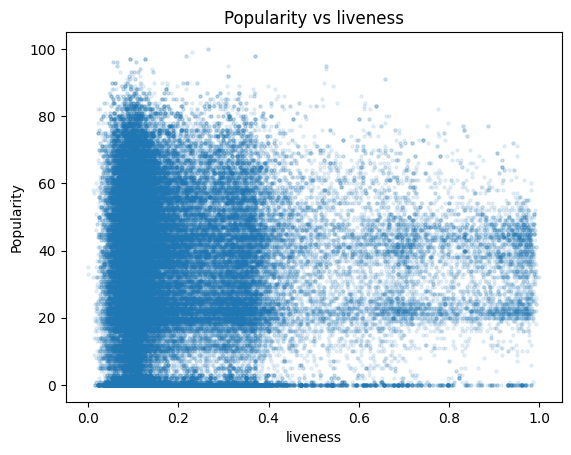

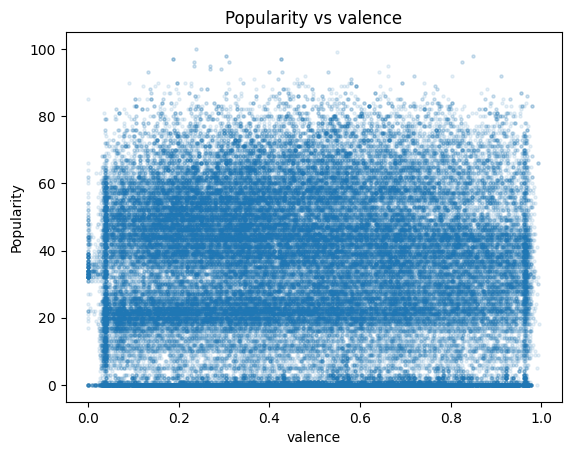

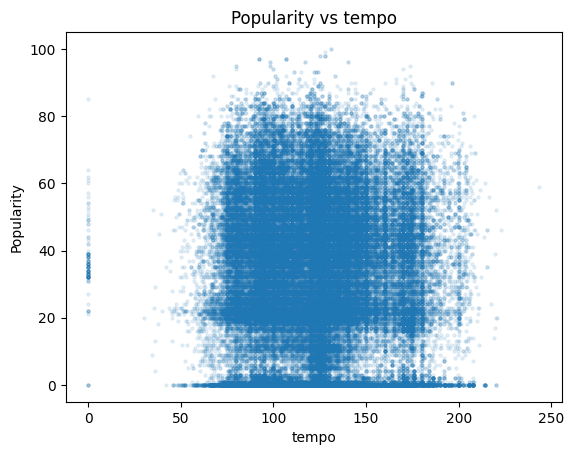

In [9]:
for col in cols_num:
    if col != "popularity":
        plt.scatter(df[col], df["popularity"], alpha=0.1, s=5)
        plt.xlabel(col)
        plt.ylabel("Popularity")
        plt.title(f"Popularity vs {col}")
        plt.show()

# Identification of some outliers and clusters, we could study further to see if they correspond to specific genres.


In [10]:
# Test the pipeline
from src.modelling.data_processing import CustomColumnScaler

df_transformer = DataFrameTransformer()
scaler = CustomColumnScaler()


X_train = pd.read_csv("../src/data/train_data.csv")
X_train = df_transformer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)
X_train.describe()


,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,is_time_signature_4,is_time_signature_0,is_time_signature_1_3_5,circle5_sin,circle5_cos
count,85500.000000,8.550000e+04,85500.000000,85500.000000,85500.000000,8.550000e+04,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,85500.000000,8.550000e+04,85500.000000,85500.000000,85500.000000,85500.0,85500.0
mean,0.331849,1.405296e-16,0.086129,0.567258,0.641617,1.226621e-16,0.637836,0.084694,0.315533,0.156024,0.213392,0.474164,2.885385e-16,0.893766,0.001415,0.104819,0.101585,0.140844
std,0.223033,1.000006e+00,0.280556,0.173209,0.251390,1.000006e+00,0.480629,0.106209,0.332890,0.309588,0.190164,0.259196,1.000006e+00,0.308139,0.037593,0.306321,0.683497,0.709004
min,0.000000,-2.078218e+00,0.000000,0.000000,0.000000,-8.215220e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.071544e+00,0.000000,0.000000,0.000000,-1.0,-1.0
25%,0.170000,-5.127736e-01,0.000000,0.457000,0.473000,-3.489620e-01,0.000000,0.035900,0.016800,0.000000,0.098000,0.260000,-7.670727e-01,1.000000,0.000000,0.000000,-0.5,-0.5
50%,0.340000,-1.434475e-01,0.000000,0.580000,0.685000,2.487852e-01,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,-2.052089e-03,1.000000,0.000000,0.000000,0.0,0.5
75%,0.500000,3.192651e-01,0.000000,0.695000,0.854000,6.478805e-01,1.000000,0.084600,0.600000,0.048600,0.273000,0.683000,6.001648e-01,1.000000,0.000000,0.000000,0.866025,0.866025
max,1.000000,4.739654e+01,1.000000,0.985000,1.000000,2.546021e+00,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,4.046026e+00,1.000000,1.000000,1.000000,1.0,1.0
